In [19]:
import numpy as np
import requests
from bs4 import BeautifulSoup
import time
import re
import pandas as pd
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
from sentence_transformers import SentenceTransformer, util
from nltk.tokenize import sent_tokenize
import torch
import nltk

In [3]:
data = pd.read_csv(r'G:\내 드라이브\DATASET\Kakao\eng_news_nocontent.csv')
data

,source,author,title,description,url,urlToImage,publishedAt,content,press
0,"{'id': None, 'name': 'Trendmicro.com'}",Trend Micro,REDBALDKNIGHT/BRONZE BUTLER’s Daserf Backdoor ...,"REDBALDKNIGHT, also known as BRONZE BUTLER and...",https://blog.trendmicro.com/trendlabs-security...,https://blog.trendmicro.com/trendlabs-security...,2017-11-07T12:34:44Z,by Joey Chen and MingYen Hsieh (Threat Analyst...,Trendmicro.com
1,"{'id': None, 'name': 'Computerworld'}","Lucas Mearian, Lucas Mearian",What is blockchain? The most disruptive tech i...,Blockchain is poised to change IT in much the ...,https://www.computerworld.com/article/3191077/...,https://images.techhive.com/images/article/201...,2017-11-08T01:06:00Z,Blockchain is poised to change IT in much the ...,Computerworld
2,"{'id': None, 'name': 'hackernoon.com'}",Yaoqi Jia,Demystifying Hashgraph: Benefits and Challenges,"Recently, on our Zilliqa social channels a num...",https://hackernoon.com/demystifying-hashgraph-...,NaN,2017-11-08T17:21:35Z,"Recently, on our Zilliqa social channels a num...",hackernoon.com
3,"{'id': None, 'name': 'Topix.com'}",NaN,BitTorrent inventor announces eco-friendly Bit...,A Bitcoin transaction wastes as much electrici...,http://www.topix.com/tech/p2p/2017/11/bittorre...,http://picproxy.topixcdn.com/pics/up-,2017-11-08T23:21:17Z,A Bitcoin transaction wastes as much electrici...,Topix.com
4,"{'id': None, 'name': 'Ml-implode.com'}",NaN,Bitcoin Fork Called Off: Prices Soar After Seg...,The price of a bitcoin went on a tear on Wedne...,http://ml-implode.com/staticnews/2017-11-09_Bi...,NaN,2017-11-09T00:00:00Z,The price of a bitcoin went on a tear on Wedne...,Ml-implode.com
...,...,...,...,...,...,...,...,...,...
744427,"{'id': None, 'name': 'Biztoc.com'}",u.today,"Negatively Correlates With Bitcoin (BTC), What...",Shiba Inu continues to focus on utility as its...,https://biztoc.com/x/8248d6342c37d743,https://c.biztoc.com/p/8248d6342c37d743/s.webp,2023-09-30T21:50:10Z,Shiba Inu continues to focus on utility as its...,Biztoc.com
744428,"{'id': None, 'name': 'Slashdot.org'}",feedfeeder,Industry leaders and policymakers weigh in on ...,Industry leaders and policymakers weigh in on ...,https://slashdot.org/firehose.pl?op=view&amp;i...,NaN,2023-09-30T21:53:20Z,Sign up for the Slashdot newsletter! OR check ...,Slashdot.org
744429,"{'id': None, 'name': 'Investing.com'}",U.Today,Shiba Inu (SHIB) Negatively Correlates With Bi...,Shiba Inu (SHIB) Negatively Correlates With Bi...,https://www.investing.com/news/cryptocurrency-...,https://i-invdn-com.investing.com/news/LYNXNPE...,2023-09-30T22:00:22Z,U.Today - Dog-themed cryptocurrency is seeing ...,Investing.com
744430,"{'id': None, 'name': 'Ambcrypto.com'}",Benjamin Njiri,Can NEAR stay above $1?,"NEAR could be ripe for a price reversal, but t...",https://ambcrypto.com/?p=347645,https://statics.ambcrypto.com/wp-content/uploa...,2023-09-30T22:30:04Z,Disclaimer: The information presented does not...,Ambcrypto.com


In [4]:
df = data

In [26]:
# 'publishedAt' 열을 datetime 객체로 변환
df['publishedAt'] = pd.to_datetime(df['publishedAt'])

# 날짜 범위 지정
start_date = '2017-12-01'
end_date = '2023-08-28'

# 날짜 범위에 해당하는 행 필터링
filtered_df = df[(df['publishedAt'] >= start_date) & (df['publishedAt'] <= end_date)]

print(filtered_df)

                                           source             author  \
7605      {'id': None, 'name': 'Daemonology.net'}                NaN   
7606    {'id': None, 'name': 'RealClearPolitics'}   Robert Samuelson   
7607       {'id': None, 'name': 'Ml-implode.com'}                NaN   
7608           {'id': None, 'name': 'Envato.com'}     Jenni McKinnon   
7609             {'id': None, 'name': 'Phoronix'}                NaN   
...                                           ...                ...   
728385         {'id': None, 'name': 'Biztoc.com'}  cointelegraph.com   
728386         {'id': None, 'name': 'Biztoc.com'}         decrypt.co   
728387           {'id': None, 'name': 'Finextra'}     Editorial Team   
728388      {'id': None, 'name': 'Ambcrypto.com'}     Benjamin Njiri   
728389         {'id': None, 'name': 'Biztoc.com'}   news.bitcoin.com   

                                                    title  \
7605                     Daily Hacker News for 2017-11-30   
7606         

In [27]:
filtered_df['title'] = filtered_df['title'].str.replace('\n', '').str.replace('\t', '')
filtered_df['title'] = filtered_df['title'].str.replace('\r', '').str.replace("\'", "'")
filtered_df['content'] = filtered_df['content'].str.replace('\n', '').str.replace('\t', '')
filtered_df['content'] = filtered_df['content'].str.replace('\r', '').str.replace("\'", "'")
filtered_df['description'] = filtered_df['description'].str.replace('\n', '').str.replace('\t', '')
filtered_df['description'] = filtered_df['description'].str.replace('\r', '').str.replace("\'", "'")
filtered_df

C:\Users\boyu571\AppData\Local\Temp\ipykernel_11324\2334299190.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['title'] = filtered_df['title'].str.replace('\n', '').str.replace('\t', '')
C:\Users\boyu571\AppData\Local\Temp\ipykernel_11324\2334299190.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['title'] = filtered_df['title'].str.replace('\r', '').str.replace("\'", "'")
C:\Users\boyu571\AppData\Local\Temp\ipykernel_11324\2334299190.py:3: SettingWithCopyWarning: 
A value is 

,source,author,title,description,url,urlToImage,publishedAt,content,press
7605,"{'id': None, 'name': 'Daemonology.net'}",NaN,Daily Hacker News for 2017-11-30,The 10 highest-rated articles on Hacker News o...,http://www.daemonology.net/hn-daily/2017-11-30...,NaN,2017-12-01 00:00:00+00:00,The 10 highest-rated articles on Hacker News o...,Daemonology.net
7606,"{'id': None, 'name': 'RealClearPolitics'}",Robert Samuelson,Beware an Economic Boom!,"WASHINGTON -- We don't need an economic boom, ...",https://www.realclearpolitics.com/articles/201...,https://assets.realclear.com/images/43/436636_...,2017-12-01 00:00:00+00:00,"WASHINGTON -- We don't need an economic boom, ...",RealClearPolitics
7607,"{'id': None, 'name': 'Ml-implode.com'}",NaN,Regulator allows bitcoin futures trading on ma...,A federal regulator [the CFTC] gave the go-ahe...,http://ml-implode.com/staticnews/2017-12-01_Re...,NaN,2017-12-01 00:00:00+00:00,A federal regulator [the CFTC] gave the go-ahe...,Ml-implode.com
7608,"{'id': None, 'name': 'Envato.com'}",Jenni McKinnon,40 Best WordPress Plugins of 2017 – December U...,Make your WordPress site even more amazing wit...,https://envato.com/blog/2017/12/01/best-wordpr...,https://assets.wordpress.envato-static.com/upl...,2017-12-01 00:00:59+00:00,Make your WordPress site even more amazing wit...,Envato.com
7609,"{'id': None, 'name': 'Phoronix'}",NaN,"Linux 4.15, Distro Performance & Open-Source R...",Ending out November were 301 original news art...,https://www.phoronix.com/scan.php?page=news_it...,NaN,2017-12-01 00:10:33+00:00,Ending out November were 301 original news art...,Phoronix
...,...,...,...,...,...,...,...,...,...
728385,"{'id': None, 'name': 'Biztoc.com'}",cointelegraph.com,Bitcoin price stability creates lucrative setu...,has gone silent over the weekend. CryptoQuant ...,https://biztoc.com/x/aad2dd70c955fe0f,https://c.biztoc.com/p/aad2dd70c955fe0f/og.webp,2023-08-27 22:18:06+00:00,has gone silent over the weekend. CryptoQuant ...,Biztoc.com
728386,"{'id': None, 'name': 'Biztoc.com'}",decrypt.co,Prime Trust Filing Reveals Cascade of Failures...,Irresponsible spending. Misjudging summer 2022...,https://biztoc.com/x/30798a6f0d4c0fe5,https://c.biztoc.com/p/30798a6f0d4c0fe5/s.webp,2023-08-27 22:20:06+00:00,Irresponsible spending. Misjudging summer 2022...,Biztoc.com
728387,"{'id': None, 'name': 'Finextra'}",Editorial Team,US Treasury sets out crypto tax reporting prop...,Cryptocurrency exchanges and payment processor...,https://www.finextra.com/newsarticle/42850/us-...,https://www.finextra.com/finextra-images/top_p...,2023-08-27 23:06:33+00:00,Cryptocurrency exchanges and payment processor...,Finextra
728388,"{'id': None, 'name': 'Ambcrypto.com'}",Benjamin Njiri,SHIB defends December lows – Will it hold for ...,SHIB's August drop eased at a crucial support ...,https://ambcrypto.com/shib-defends-december-lo...,https://statics.ambcrypto.com/wp-content/uploa...,2023-08-27 23:30:48+00:00,Disclaimer: The information presented does not...,Ambcrypto.com


In [28]:
filtered_df = filtered_df.drop_duplicates(subset='title')
filtered_df

,source,author,title,description,url,urlToImage,publishedAt,content,press
7605,"{'id': None, 'name': 'Daemonology.net'}",NaN,Daily Hacker News for 2017-11-30,The 10 highest-rated articles on Hacker News o...,http://www.daemonology.net/hn-daily/2017-11-30...,NaN,2017-12-01 00:00:00+00:00,The 10 highest-rated articles on Hacker News o...,Daemonology.net
7606,"{'id': None, 'name': 'RealClearPolitics'}",Robert Samuelson,Beware an Economic Boom!,"WASHINGTON -- We don't need an economic boom, ...",https://www.realclearpolitics.com/articles/201...,https://assets.realclear.com/images/43/436636_...,2017-12-01 00:00:00+00:00,"WASHINGTON -- We don't need an economic boom, ...",RealClearPolitics
7607,"{'id': None, 'name': 'Ml-implode.com'}",NaN,Regulator allows bitcoin futures trading on ma...,A federal regulator [the CFTC] gave the go-ahe...,http://ml-implode.com/staticnews/2017-12-01_Re...,NaN,2017-12-01 00:00:00+00:00,A federal regulator [the CFTC] gave the go-ahe...,Ml-implode.com
7608,"{'id': None, 'name': 'Envato.com'}",Jenni McKinnon,40 Best WordPress Plugins of 2017 – December U...,Make your WordPress site even more amazing wit...,https://envato.com/blog/2017/12/01/best-wordpr...,https://assets.wordpress.envato-static.com/upl...,2017-12-01 00:00:59+00:00,Make your WordPress site even more amazing wit...,Envato.com
7609,"{'id': None, 'name': 'Phoronix'}",NaN,"Linux 4.15, Distro Performance & Open-Source R...",Ending out November were 301 original news art...,https://www.phoronix.com/scan.php?page=news_it...,NaN,2017-12-01 00:10:33+00:00,Ending out November were 301 original news art...,Phoronix
...,...,...,...,...,...,...,...,...,...
728383,"{'id': None, 'name': 'Decrypt'}",Nicholas Morgan,Prime Trust Filing Reveals Cascade of Failures...,The company recounted a litany of mistakes tha...,https://decrypt.co/153954/prime-trust-bankrupt...,https://cdn.decrypt.co/resize/1024/height/512/...,2023-08-27 22:08:45+00:00,Irresponsible spending. Misjudging summer 2022...,Decrypt
728384,"{'id': None, 'name': 'Yahoo Entertainment'}",Brett Miller,Asia Stocks Set for Small Gains; Currencies St...,(Bloomberg) -- Asian stocks look poised to fol...,https://finance.yahoo.com/news/asia-stocks-set...,https://s.yimg.com/ny/api/res/1.2/Fw277VysWWw9...,2023-08-27 22:09:00+00:00,(Bloomberg) -- Asian stocks look poised to fol...,Yahoo Entertainment
728387,"{'id': None, 'name': 'Finextra'}",Editorial Team,US Treasury sets out crypto tax reporting prop...,Cryptocurrency exchanges and payment processor...,https://www.finextra.com/newsarticle/42850/us-...,https://www.finextra.com/finextra-images/top_p...,2023-08-27 23:06:33+00:00,Cryptocurrency exchanges and payment processor...,Finextra
728388,"{'id': None, 'name': 'Ambcrypto.com'}",Benjamin Njiri,SHIB defends December lows – Will it hold for ...,SHIB's August drop eased at a crucial support ...,https://ambcrypto.com/shib-defends-december-lo...,https://statics.ambcrypto.com/wp-content/uploa...,2023-08-27 23:30:48+00:00,Disclaimer: The information presented does not...,Ambcrypto.com


In [29]:
filtered_df = filtered_df[~filtered_df['title'].isna()]
filtered_df

,source,author,title,description,url,urlToImage,publishedAt,content,press
7605,"{'id': None, 'name': 'Daemonology.net'}",NaN,Daily Hacker News for 2017-11-30,The 10 highest-rated articles on Hacker News o...,http://www.daemonology.net/hn-daily/2017-11-30...,NaN,2017-12-01 00:00:00+00:00,The 10 highest-rated articles on Hacker News o...,Daemonology.net
7606,"{'id': None, 'name': 'RealClearPolitics'}",Robert Samuelson,Beware an Economic Boom!,"WASHINGTON -- We don't need an economic boom, ...",https://www.realclearpolitics.com/articles/201...,https://assets.realclear.com/images/43/436636_...,2017-12-01 00:00:00+00:00,"WASHINGTON -- We don't need an economic boom, ...",RealClearPolitics
7607,"{'id': None, 'name': 'Ml-implode.com'}",NaN,Regulator allows bitcoin futures trading on ma...,A federal regulator [the CFTC] gave the go-ahe...,http://ml-implode.com/staticnews/2017-12-01_Re...,NaN,2017-12-01 00:00:00+00:00,A federal regulator [the CFTC] gave the go-ahe...,Ml-implode.com
7608,"{'id': None, 'name': 'Envato.com'}",Jenni McKinnon,40 Best WordPress Plugins of 2017 – December U...,Make your WordPress site even more amazing wit...,https://envato.com/blog/2017/12/01/best-wordpr...,https://assets.wordpress.envato-static.com/upl...,2017-12-01 00:00:59+00:00,Make your WordPress site even more amazing wit...,Envato.com
7609,"{'id': None, 'name': 'Phoronix'}",NaN,"Linux 4.15, Distro Performance & Open-Source R...",Ending out November were 301 original news art...,https://www.phoronix.com/scan.php?page=news_it...,NaN,2017-12-01 00:10:33+00:00,Ending out November were 301 original news art...,Phoronix
...,...,...,...,...,...,...,...,...,...
728383,"{'id': None, 'name': 'Decrypt'}",Nicholas Morgan,Prime Trust Filing Reveals Cascade of Failures...,The company recounted a litany of mistakes tha...,https://decrypt.co/153954/prime-trust-bankrupt...,https://cdn.decrypt.co/resize/1024/height/512/...,2023-08-27 22:08:45+00:00,Irresponsible spending. Misjudging summer 2022...,Decrypt
728384,"{'id': None, 'name': 'Yahoo Entertainment'}",Brett Miller,Asia Stocks Set for Small Gains; Currencies St...,(Bloomberg) -- Asian stocks look poised to fol...,https://finance.yahoo.com/news/asia-stocks-set...,https://s.yimg.com/ny/api/res/1.2/Fw277VysWWw9...,2023-08-27 22:09:00+00:00,(Bloomberg) -- Asian stocks look poised to fol...,Yahoo Entertainment
728387,"{'id': None, 'name': 'Finextra'}",Editorial Team,US Treasury sets out crypto tax reporting prop...,Cryptocurrency exchanges and payment processor...,https://www.finextra.com/newsarticle/42850/us-...,https://www.finextra.com/finextra-images/top_p...,2023-08-27 23:06:33+00:00,Cryptocurrency exchanges and payment processor...,Finextra
728388,"{'id': None, 'name': 'Ambcrypto.com'}",Benjamin Njiri,SHIB defends December lows – Will it hold for ...,SHIB's August drop eased at a crucial support ...,https://ambcrypto.com/shib-defends-december-lo...,https://statics.ambcrypto.com/wp-content/uploa...,2023-08-27 23:30:48+00:00,Disclaimer: The information presented does not...,Ambcrypto.com


In [30]:
# df_content = df_content.sort_values('time').reset_index(drop=True)
filtered_df.rename(columns={'publishedAt': 'time'}, inplace=True)
filtered_df['time'] = pd.to_datetime(filtered_df['time'])
filtered_df['date'] = filtered_df['time'].dt.date
filtered_df

C:\Users\boyu571\AppData\Local\Temp\ipykernel_11324\152352263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.rename(columns={'publishedAt': 'time'}, inplace=True)
C:\Users\boyu571\AppData\Local\Temp\ipykernel_11324\152352263.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['time'] = pd.to_datetime(filtered_df['time'])
C:\Users\boyu571\AppData\Local\Temp\ipykernel_11324\152352263.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



,source,author,title,description,url,urlToImage,time,content,press,date
7605,"{'id': None, 'name': 'Daemonology.net'}",NaN,Daily Hacker News for 2017-11-30,The 10 highest-rated articles on Hacker News o...,http://www.daemonology.net/hn-daily/2017-11-30...,NaN,2017-12-01 00:00:00+00:00,The 10 highest-rated articles on Hacker News o...,Daemonology.net,2017-12-01
7606,"{'id': None, 'name': 'RealClearPolitics'}",Robert Samuelson,Beware an Economic Boom!,"WASHINGTON -- We don't need an economic boom, ...",https://www.realclearpolitics.com/articles/201...,https://assets.realclear.com/images/43/436636_...,2017-12-01 00:00:00+00:00,"WASHINGTON -- We don't need an economic boom, ...",RealClearPolitics,2017-12-01
7607,"{'id': None, 'name': 'Ml-implode.com'}",NaN,Regulator allows bitcoin futures trading on ma...,A federal regulator [the CFTC] gave the go-ahe...,http://ml-implode.com/staticnews/2017-12-01_Re...,NaN,2017-12-01 00:00:00+00:00,A federal regulator [the CFTC] gave the go-ahe...,Ml-implode.com,2017-12-01
7608,"{'id': None, 'name': 'Envato.com'}",Jenni McKinnon,40 Best WordPress Plugins of 2017 – December U...,Make your WordPress site even more amazing wit...,https://envato.com/blog/2017/12/01/best-wordpr...,https://assets.wordpress.envato-static.com/upl...,2017-12-01 00:00:59+00:00,Make your WordPress site even more amazing wit...,Envato.com,2017-12-01
7609,"{'id': None, 'name': 'Phoronix'}",NaN,"Linux 4.15, Distro Performance & Open-Source R...",Ending out November were 301 original news art...,https://www.phoronix.com/scan.php?page=news_it...,NaN,2017-12-01 00:10:33+00:00,Ending out November were 301 original news art...,Phoronix,2017-12-01
...,...,...,...,...,...,...,...,...,...,...
728383,"{'id': None, 'name': 'Decrypt'}",Nicholas Morgan,Prime Trust Filing Reveals Cascade of Failures...,The company recounted a litany of mistakes tha...,https://decrypt.co/153954/prime-trust-bankrupt...,https://cdn.decrypt.co/resize/1024/height/512/...,2023-08-27 22:08:45+00:00,Irresponsible spending. Misjudging summer 2022...,Decrypt,2023-08-27
728384,"{'id': None, 'name': 'Yahoo Entertainment'}",Brett Miller,Asia Stocks Set for Small Gains; Currencies St...,(Bloomberg) -- Asian stocks look poised to fol...,https://finance.yahoo.com/news/asia-stocks-set...,https://s.yimg.com/ny/api/res/1.2/Fw277VysWWw9...,2023-08-27 22:09:00+00:00,(Bloomberg) -- Asian stocks look poised to fol...,Yahoo Entertainment,2023-08-27
728387,"{'id': None, 'name': 'Finextra'}",Editorial Team,US Treasury sets out crypto tax reporting prop...,Cryptocurrency exchanges and payment processor...,https://www.finextra.com/newsarticle/42850/us-...,https://www.finextra.com/finextra-images/top_p...,2023-08-27 23:06:33+00:00,Cryptocurrency exchanges and payment processor...,Finextra,2023-08-27
728388,"{'id': None, 'name': 'Ambcrypto.com'}",Benjamin Njiri,SHIB defends December lows – Will it hold for ...,SHIB's August drop eased at a crucial support ...,https://ambcrypto.com/shib-defends-december-lo...,https://statics.ambcrypto.com/wp-content/uploa...,2023-08-27 23:30:48+00:00,Disclaimer: The information presented does not...,Ambcrypto.com,2023-08-27


In [31]:
filtered_df.to_csv('first_processed_eng_data_v2.csv', encoding='utf-8-sig', index=False)

In [20]:
df = pd.read_csv(r'G:\내 드라이브\DATASET\Kakao\eng_data_processed\first\first_processed_eng_data_v2.csv')
df

,source,author,title,description,url,urlToImage,time,content,press,date
0,"{'id': None, 'name': 'Daemonology.net'}",NaN,Daily Hacker News for 2017-11-30,The 10 highest-rated articles on Hacker News o...,http://www.daemonology.net/hn-daily/2017-11-30...,NaN,2017-12-01 00:00:00+00:00,The 10 highest-rated articles on Hacker News o...,Daemonology.net,2017-12-01
1,"{'id': None, 'name': 'RealClearPolitics'}",Robert Samuelson,Beware an Economic Boom!,"WASHINGTON -- We don't need an economic boom, ...",https://www.realclearpolitics.com/articles/201...,https://assets.realclear.com/images/43/436636_...,2017-12-01 00:00:00+00:00,"WASHINGTON -- We don't need an economic boom, ...",RealClearPolitics,2017-12-01
2,"{'id': None, 'name': 'Ml-implode.com'}",NaN,Regulator allows bitcoin futures trading on ma...,A federal regulator [the CFTC] gave the go-ahe...,http://ml-implode.com/staticnews/2017-12-01_Re...,NaN,2017-12-01 00:00:00+00:00,A federal regulator [the CFTC] gave the go-ahe...,Ml-implode.com,2017-12-01
3,"{'id': None, 'name': 'Envato.com'}",Jenni McKinnon,40 Best WordPress Plugins of 2017 – December U...,Make your WordPress site even more amazing wit...,https://envato.com/blog/2017/12/01/best-wordpr...,https://assets.wordpress.envato-static.com/upl...,2017-12-01 00:00:59+00:00,Make your WordPress site even more amazing wit...,Envato.com,2017-12-01
4,"{'id': None, 'name': 'Phoronix'}",NaN,"Linux 4.15, Distro Performance & Open-Source R...",Ending out November were 301 original news art...,https://www.phoronix.com/scan.php?page=news_it...,NaN,2017-12-01 00:10:33+00:00,Ending out November were 301 original news art...,Phoronix,2017-12-01
...,...,...,...,...,...,...,...,...,...,...
634606,"{'id': None, 'name': 'Decrypt'}",Nicholas Morgan,Prime Trust Filing Reveals Cascade of Failures...,The company recounted a litany of mistakes tha...,https://decrypt.co/153954/prime-trust-bankrupt...,https://cdn.decrypt.co/resize/1024/height/512/...,2023-08-27 22:08:45+00:00,Irresponsible spending. Misjudging summer 2022...,Decrypt,2023-08-27
634607,"{'id': None, 'name': 'Yahoo Entertainment'}",Brett Miller,Asia Stocks Set for Small Gains; Currencies St...,(Bloomberg) -- Asian stocks look poised to fol...,https://finance.yahoo.com/news/asia-stocks-set...,https://s.yimg.com/ny/api/res/1.2/Fw277VysWWw9...,2023-08-27 22:09:00+00:00,(Bloomberg) -- Asian stocks look poised to fol...,Yahoo Entertainment,2023-08-27
634608,"{'id': None, 'name': 'Finextra'}",Editorial Team,US Treasury sets out crypto tax reporting prop...,Cryptocurrency exchanges and payment processor...,https://www.finextra.com/newsarticle/42850/us-...,https://www.finextra.com/finextra-images/top_p...,2023-08-27 23:06:33+00:00,Cryptocurrency exchanges and payment processor...,Finextra,2023-08-27
634609,"{'id': None, 'name': 'Ambcrypto.com'}",Benjamin Njiri,SHIB defends December lows – Will it hold for ...,SHIB's August drop eased at a crucial support ...,https://ambcrypto.com/shib-defends-december-lo...,https://statics.ambcrypto.com/wp-content/uploa...,2023-08-27 23:30:48+00:00,Disclaimer: The information presented does not...,Ambcrypto.com,2023-08-27


In [21]:
# sBERT 모델 로드
model = SentenceTransformer('paraphrase-distilroberta-base-v1')

# 코사인 유사도 계산 함수
def cosine_similarity(embedding1, embedding2):
    return util.pytorch_cos_sim(embedding1, embedding2)

# 문서 임베딩 생성 함수
# def create_document_embeddings(sentences):
#     sentence_embeddings = model.encode(sentences, convert_to_tensor=True)
#     document_embedding = torch.mean(sentence_embeddings, dim=0)
#     return document_embedding

def create_document_embeddings(sentences):
    if not sentences:  # Check if the list of sentences is empty
        return None  # Return None if there are no sentences to encode
    try:
        sentence_embeddings = model.encode(sentences, convert_to_tensor=True)
        document_embedding = torch.mean(sentence_embeddings, dim=0)
        return document_embedding
    except Exception as e:
        print(f"Error in create_document_embeddings: {e}")
        print(f"Sentences: {sentences}")
        return None  # Return None in case of any other error

def cluster_and_filter_articles(group):
    filtered_group = pd.DataFrame()
    try:
        document_embeddings = []
        for _, row in group.iterrows():
            # 결측치를 공백으로 처리
            title = str(row['title']) if not pd.isna(row['title']) else ''
            description = str(row['description']) if not pd.isna(row['description']) else ''

            # title과 description 결합
            content = title + ' ' + description
            embedding = create_document_embeddings(sent_tokenize(content))
            if embedding is not None:
                document_embeddings.append(embedding)

        if not document_embeddings:
            return filtered_group  # If no embeddings, return empty DataFrame

        similarity_matrix = compute_similarity_matrix(document_embeddings)
        clusters = []
        visited = np.zeros(len(document_embeddings), dtype=bool)

        for i in range(len(document_embeddings)):
            if not visited[i]:
                similar_articles = np.where(np.array(similarity_matrix[i]) > 0.6)[0]
                clusters.append(similar_articles)
                visited[similar_articles] = True

        representative_indices = [cluster[0] for cluster in clusters if len(cluster) > 0]
        if representative_indices:
            filtered_group = group.iloc[representative_indices].reset_index(drop=True)
    except Exception as e:
        print(f"Error in cluster_and_filter_articles: {e}")
    
    return filtered_group

# 유사도 행렬 계산 함수
def compute_similarity_matrix(document_embeddings):
    similarity_matrix = []
    for embedding1 in document_embeddings:
        row = []
        for embedding2 in document_embeddings:
            similarity = cosine_similarity(embedding1, embedding2).item()
            row.append(similarity)
        similarity_matrix.append(row)
    return similarity_matrix

In [23]:
grouped_data = df.groupby('date')
filtered_data = pd.DataFrame()

for date, group in grouped_data:
    try:
        filtered_group = cluster_and_filter_articles(group)
        if not filtered_group.empty:
            filtered_data = pd.concat([filtered_data, filtered_group], ignore_index=True)
    except Exception as e:
        print(f"Error at date {date}: {e}")

print(filtered_data)

                                             source            author  \
0           {'id': None, 'name': 'Daemonology.net'}               NaN   
1         {'id': None, 'name': 'RealClearPolitics'}  Robert Samuelson   
2            {'id': None, 'name': 'Ml-implode.com'}               NaN   
3                {'id': None, 'name': 'Envato.com'}    Jenni McKinnon   
4                  {'id': None, 'name': 'Phoronix'}               NaN   
...                                             ...               ...   
507742              {'id': None, 'name': 'Decrypt'}   Nicholas Morgan   
507743  {'id': None, 'name': 'Yahoo Entertainment'}      Brett Miller   
507744             {'id': None, 'name': 'Finextra'}    Editorial Team   
507745        {'id': None, 'name': 'Ambcrypto.com'}    Benjamin Njiri   
507746           {'id': None, 'name': 'Biztoc.com'}  news.bitcoin.com   

                                                    title  \
0                        Daily Hacker News for 2017-11-30   
1

In [24]:
filtered_data

,source,author,title,description,url,urlToImage,time,content,press,date
0,"{'id': None, 'name': 'Daemonology.net'}",NaN,Daily Hacker News for 2017-11-30,The 10 highest-rated articles on Hacker News o...,http://www.daemonology.net/hn-daily/2017-11-30...,NaN,2017-12-01 00:00:00+00:00,The 10 highest-rated articles on Hacker News o...,Daemonology.net,2017-12-01
1,"{'id': None, 'name': 'RealClearPolitics'}",Robert Samuelson,Beware an Economic Boom!,"WASHINGTON -- We don't need an economic boom, ...",https://www.realclearpolitics.com/articles/201...,https://assets.realclear.com/images/43/436636_...,2017-12-01 00:00:00+00:00,"WASHINGTON -- We don't need an economic boom, ...",RealClearPolitics,2017-12-01
2,"{'id': None, 'name': 'Ml-implode.com'}",NaN,Regulator allows bitcoin futures trading on ma...,A federal regulator [the CFTC] gave the go-ahe...,http://ml-implode.com/staticnews/2017-12-01_Re...,NaN,2017-12-01 00:00:00+00:00,A federal regulator [the CFTC] gave the go-ahe...,Ml-implode.com,2017-12-01
3,"{'id': None, 'name': 'Envato.com'}",Jenni McKinnon,40 Best WordPress Plugins of 2017 – December U...,Make your WordPress site even more amazing wit...,https://envato.com/blog/2017/12/01/best-wordpr...,https://assets.wordpress.envato-static.com/upl...,2017-12-01 00:00:59+00:00,Make your WordPress site even more amazing wit...,Envato.com,2017-12-01
4,"{'id': None, 'name': 'Phoronix'}",NaN,"Linux 4.15, Distro Performance & Open-Source R...",Ending out November were 301 original news art...,https://www.phoronix.com/scan.php?page=news_it...,NaN,2017-12-01 00:10:33+00:00,Ending out November were 301 original news art...,Phoronix,2017-12-01
...,...,...,...,...,...,...,...,...,...,...
507742,"{'id': None, 'name': 'Decrypt'}",Nicholas Morgan,Prime Trust Filing Reveals Cascade of Failures...,The company recounted a litany of mistakes tha...,https://decrypt.co/153954/prime-trust-bankrupt...,https://cdn.decrypt.co/resize/1024/height/512/...,2023-08-27 22:08:45+00:00,Irresponsible spending. Misjudging summer 2022...,Decrypt,2023-08-27
507743,"{'id': None, 'name': 'Yahoo Entertainment'}",Brett Miller,Asia Stocks Set for Small Gains; Currencies St...,(Bloomberg) -- Asian stocks look poised to fol...,https://finance.yahoo.com/news/asia-stocks-set...,https://s.yimg.com/ny/api/res/1.2/Fw277VysWWw9...,2023-08-27 22:09:00+00:00,(Bloomberg) -- Asian stocks look poised to fol...,Yahoo Entertainment,2023-08-27
507744,"{'id': None, 'name': 'Finextra'}",Editorial Team,US Treasury sets out crypto tax reporting prop...,Cryptocurrency exchanges and payment processor...,https://www.finextra.com/newsarticle/42850/us-...,https://www.finextra.com/finextra-images/top_p...,2023-08-27 23:06:33+00:00,Cryptocurrency exchanges and payment processor...,Finextra,2023-08-27
507745,"{'id': None, 'name': 'Ambcrypto.com'}",Benjamin Njiri,SHIB defends December lows – Will it hold for ...,SHIB's August drop eased at a crucial support ...,https://ambcrypto.com/shib-defends-december-lo...,https://statics.ambcrypto.com/wp-content/uploa...,2023-08-27 23:30:48+00:00,Disclaimer: The information presented does not...,Ambcrypto.com,2023-08-27


In [25]:
filtered_data.to_csv(r'G:\내 드라이브\DATASET\Kakao\eng_data_processed\second\second_processed_eng_data_title_ver.csv', encoding='utf-8-sig', index=False)

In [7]:
part2_data = pd.read_csv('eng_ver1_part2.csv')
part2_data

,source,author,title,description,url,urlToImage,time,content,press,content_full,date
0,"{'id': None, 'name': 'Activistpost.com'}",Activist Post,Got Google Smart Home Speakers? Researcher Rev...,"By B.N. Frank Over the years, countless expert...",https://www.activistpost.com/2022/12/got-googl...,https://www.activistpost.com/wp-content/upload...,2023-01-01 00:02:08+00:00,"By B.N. Frank\r\nOver the years, countless exp...",Activistpost.com,"By B.N. Frank Over the years, countless expert...",2023-01-01
1,"{'id': None, 'name': 'U.Today'}",U.Today,Satoshi Nakamoto: Here Are Top News Related to...,U.Today wrapped up the hottest news about Bitc...,https://u.today/satoshi-nakamoto-here-are-top-...,https://u.today/sites/default/files/styles/twi...,2023-01-01 01:00:00+00:00,The true identity of enigmatic Bitcoin creator...,U.Today,The true identity of enigmatic Bitcoin creator...,2023-01-01
2,"{'id': None, 'name': 'Independent.ie'}",Gabrielle Monaghan,‘You can lose a lot of money’ – Watchdog to ta...,Consumer watchdog The Competition and Consumer...,https://www.independent.ie/business/irish/you-...,https://www.independent.ie/business/irish/41fa...,2023-01-01 02:30:00+00:00,Consumer watchdog The Competition and Consumer...,Independent.ie,Consumer watchdog The Competition and Consumer...,2023-01-01
3,"{'id': None, 'name': 'Ambcrypto.com'}",Suzuki Shillsalot,Cardano [ADA]: Risk-averse traders can lock ga...,Disclaimer: The information presented does not...,https://ambcrypto.com/cardano-ada-risk-averse-...,https://ambcrypto.com/wp-content/uploads/2022/...,2023-01-01 03:30:26+00:00,Disclaimer: The information presented does not...,Ambcrypto.com,Disclaimer: The information presented does not...,2023-01-01
4,"{'id': None, 'name': 'CryptoGlobe'}",Guest Contributor,Does Binance Have Deposit Limits?,Binance is one of the most popular cryptocurre...,https://www.cryptoglobe.com/latest/2023/01/bin...,https://cryptoglobe.s3.eu-west-2.amazonaws.com...,2023-01-01 03:31:00+00:00,Binance is one of the most popular cryptocurre...,CryptoGlobe,Binance is one of the most popular cryptocurre...,2023-01-01
...,...,...,...,...,...,...,...,...,...,...,...
12199,"{'id': None, 'name': 'Cointelegraph'}",Cointelegraph By Brayden Lindrea,Redditor's hacked Bitcoin is a lesson on the h...,Blockchain security firm CertiK warns crypto h...,https://cointelegraph.com/news/redditor-gets-l...,https://images.cointelegraph.com/images/1200_a...,2023-07-27 04:08:19+00:00,A Reddit user has become the latest example of...,Cointelegraph,A Reddit user has become the latest example of...,2023-07-27 00:00:00
12200,"{'id': None, 'name': 'The Daily Hodl'}",Daily Hodl Staff,One Catalyst Could Trigger Bitcoin To Explode ...,Fundstrat Global Advisors’ managing partner To...,https://dailyhodl.com/2023/07/27/one-catalyst-...,https://dailyhodl.com/wp-content/uploads/2023/...,2023-07-27 07:04:40+00:00,Fundstrat Global Advisors managing partner Tom...,The Daily Hodl,Fundstrat Global Advisors’ managing partner To...,2023-07-27 00:00:00
12201,"{'id': None, 'name': 'Cointelegraph'}",Cointelegraph By Tom Mitchelhill,Robert Kennedy Jr. admits to buying 2 Bitcoin ...,Democratic presidential hopeful Robert F. Kenn...,https://cointelegraph.com/news/presidential-ca...,https://images.cointelegraph.com/images/1200_a...,2023-07-27 03:13:58+00:00,Democratic presidential candidate Robert F. Ke...,Cointelegraph,Democratic presidential candidate Robert F. Ke...,2023-07-27 00:00:00
12202,"{'id': None, 'name': 'MarketWatch'}",Jon Swartz,: Sequoia Capital hacks crypto fund as part of...,Storied venture-capital firm Sequoia Capital h...,https://www.marketwatch.com/story/sequoia-capi...,https://s.wsj.net/public/resources/MWimages/MW...,2023-07-27 21:11:00+00:00,Storied venture-capital firm Sequoia Capital h...,MarketWatch,Storied venture-capital firm Sequoia Capital h...,2023-07-27 00:00:00


In [18]:
data_first_half = pd.concat([final_df, final_df_2, final_df_3], ignore_index=True)

data_first_half

,source,author,title,description,url,urlToImage,time,content,press,content_full,date
0,"{'id': None, 'name': 'Activistpost.com'}",Activist Post,Got Google Smart Home Speakers? Researcher Rev...,"By B.N. Frank Over the years, countless expert...",https://www.activistpost.com/2022/12/got-googl...,https://www.activistpost.com/wp-content/upload...,2023-01-01 00:02:08+00:00,"By B.N. Frank\r\nOver the years, countless exp...",Activistpost.com,"By B.N. Frank Over the years, countless expert...",2023-01-01
1,"{'id': None, 'name': 'U.Today'}",U.Today,Satoshi Nakamoto: Here Are Top News Related to...,U.Today wrapped up the hottest news about Bitc...,https://u.today/satoshi-nakamoto-here-are-top-...,https://u.today/sites/default/files/styles/twi...,2023-01-01 01:00:00+00:00,The true identity of enigmatic Bitcoin creator...,U.Today,The true identity of enigmatic Bitcoin creator...,2023-01-01
2,"{'id': None, 'name': 'Independent.ie'}",Gabrielle Monaghan,‘You can lose a lot of money’ – Watchdog to ta...,Consumer watchdog The Competition and Consumer...,https://www.independent.ie/business/irish/you-...,https://www.independent.ie/business/irish/41fa...,2023-01-01 02:30:00+00:00,Consumer watchdog The Competition and Consumer...,Independent.ie,Consumer watchdog The Competition and Consumer...,2023-01-01
3,"{'id': None, 'name': 'Ambcrypto.com'}",Suzuki Shillsalot,Cardano [ADA]: Risk-averse traders can lock ga...,Disclaimer: The information presented does not...,https://ambcrypto.com/cardano-ada-risk-averse-...,https://ambcrypto.com/wp-content/uploads/2022/...,2023-01-01 03:30:26+00:00,Disclaimer: The information presented does not...,Ambcrypto.com,Disclaimer: The information presented does not...,2023-01-01
4,"{'id': None, 'name': 'CryptoGlobe'}",Guest Contributor,Does Binance Have Deposit Limits?,Binance is one of the most popular cryptocurre...,https://www.cryptoglobe.com/latest/2023/01/bin...,https://cryptoglobe.s3.eu-west-2.amazonaws.com...,2023-01-01 03:31:00+00:00,Binance is one of the most popular cryptocurre...,CryptoGlobe,Binance is one of the most popular cryptocurre...,2023-01-01
...,...,...,...,...,...,...,...,...,...,...,...
12199,"{'id': None, 'name': 'Cointelegraph'}",Cointelegraph By Brayden Lindrea,Redditor's hacked Bitcoin is a lesson on the h...,Blockchain security firm CertiK warns crypto h...,https://cointelegraph.com/news/redditor-gets-l...,https://images.cointelegraph.com/images/1200_a...,2023-07-27 04:08:19+00:00,A Reddit user has become the latest example of...,Cointelegraph,A Reddit user has become the latest example of...,2023-07-27 00:00:00
12200,"{'id': None, 'name': 'The Daily Hodl'}",Daily Hodl Staff,One Catalyst Could Trigger Bitcoin To Explode ...,Fundstrat Global Advisors’ managing partner To...,https://dailyhodl.com/2023/07/27/one-catalyst-...,https://dailyhodl.com/wp-content/uploads/2023/...,2023-07-27 07:04:40+00:00,Fundstrat Global Advisors managing partner Tom...,The Daily Hodl,Fundstrat Global Advisors’ managing partner To...,2023-07-27 00:00:00
12201,"{'id': None, 'name': 'Cointelegraph'}",Cointelegraph By Tom Mitchelhill,Robert Kennedy Jr. admits to buying 2 Bitcoin ...,Democratic presidential hopeful Robert F. Kenn...,https://cointelegraph.com/news/presidential-ca...,https://images.cointelegraph.com/images/1200_a...,2023-07-27 03:13:58+00:00,Democratic presidential candidate Robert F. Ke...,Cointelegraph,Democratic presidential candidate Robert F. Ke...,2023-07-27 00:00:00
12202,"{'id': None, 'name': 'MarketWatch'}",Jon Swartz,: Sequoia Capital hacks crypto fund as part of...,Storied venture-capital firm Sequoia Capital h...,https://www.marketwatch.com/story/sequoia-capi...,https://s.wsj.net/public/resources/MWimages/MW...,2023-07-27 21:11:00+00:00,Storied venture-capital firm Sequoia Capital h...,MarketWatch,Storied venture-capital firm Sequoia Capital h...,2023-07-27 00:00:00


In [6]:
data1 = pd.read_csv(r'G:\내 드라이브\DATASET\Kakao\eng_data_processed\second\eng_ver1_part1.csv')
data2 = pd.read_csv(r'G:\내 드라이브\DATASET\Kakao\eng_data_processed\second\eng_ver1_part2.csv')


61595

In [3]:
data = pd.read_csv(r'G:\내 드라이브\DATASET\Kakao\eng_data_processed\second\second_processed_eng_data.csv')

In [6]:
df = data

In [12]:
# 'date' 열을 날짜 형식으로 변환
df['date'] = pd.to_datetime(df['date'])

# 날짜 범위 지정
start_date = '2017-12-01'
end_date = '2023-08-28'

# 날짜 범위에 해당하는 행 필터링
filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

print(filtered_df)

                                                   source  \
922     {'id': None, 'name': 'AllAfrica - Top Africa N...   
923                  {'id': None, 'name': 'Bangkok Post'}   
924                      {'id': None, 'name': "Barron's"}   
925                {'id': 'bbc-news', 'name': 'BBC News'}   
926                {'id': 'bbc-news', 'name': 'BBC News'}   
...                                                   ...   
103864            {'id': None, 'name': 'Theregister.com'}   
103865         {'id': None, 'name': 'Marketscreener.com'}   
103866                    {'id': None, 'name': 'Decrypt'}   
103867              {'id': None, 'name': 'Cointelegraph'}   
103868             {'id': None, 'name': 'Gadgets360.com'}   

                                     author  \
922                                     NaN   
923     Bangkok Post Public Company Limited   
924                             Avi Salzman   
925        https://www.facebook.com/bbcnews   
926        https://www.facebook.

In [13]:
final_data = filtered_df
final_data

,source,author,title,description,url,urlToImage,time,content,press,content_full,date
922,"{'id': None, 'name': 'AllAfrica - Top Africa N...",NaN,CBN to Harness Opportunities in Fintechs,"[This Day] The Deputy Governor, Economic polic...",http://allafrica.com/stories/201712010615.html,http://allafrica.com/static/images/structure/a...,2017-12-01 14:27:33+00:00,"By Ikenna Ekwerike The Deputy Governor, Econom...",AllAfrica - Top Africa News,"The Deputy Governor, Economic policy, Central...",2017-12-01
923,"{'id': None, 'name': 'Bangkok Post'}",Bangkok Post Public Company Limited,"Tax optimism drives Dow, year-end fund buys he...","Recap: US stocks surged this week, with the Do...",https://www.bangkokpost.com/business/news/1370...,https://www.bangkokpost.com/media/content/2017...,2017-12-01 21:04:00+00:00,"Recap: US stocks surged this week, with the Do...",Bangkok Post,"Recap: US stocks surged this week, with the Do...",2017-12-01
924,"{'id': None, 'name': ""Barron's""}",Avi Salzman,"Ready or Not, Here We Come! Bitcoin Preps for ...","Wall Street, start your engines, and be sure t...",http://www.barrons.com/articles/ready-or-not-h...,https://s.wsj.net/img/barrons/social_highres.jpg,2017-12-01 14:22:00+00:00,The Chicago Mercantile Exchange announced earl...,Barron's,"Wall Street, start your engines, and be sure t...",2017-12-01
925,"{'id': 'bbc-news', 'name': 'BBC News'}",https://www.facebook.com/bbcnews,Cyber-thieves seek to cash in on Bitcoin boom,The Bitcoin boom has prompted a massive rise i...,http://www.bbc.co.uk/news/technology-41469232,https://ichef-1.bbci.co.uk/news/1024/cpsprodpb...,2017-12-01 08:09:51+00:00,Image copyright AFP Image caption Bitcoin is v...,BBC News,Cyber-thieves seek to cash in on Bitcoin boomP...,2017-12-01
926,"{'id': 'bbc-news', 'name': 'BBC News'}",https://www.facebook.com/bbcnews,US regulator approves Bitcoin trading,The Commodity Futures Trading Commission will ...,http://www.bbc.co.uk/news/business-42199260,https://ichef.bbci.co.uk/news/1024/cpsprodpb/1...,2017-12-01 16:06:22+00:00,Image copyright Reuters Image caption The cryp...,BBC News,US regulator approves Bitcoin tradingPublished...,2017-12-01
...,...,...,...,...,...,...,...,...,...,...,...
103864,"{'id': None, 'name': 'Theregister.com'}",Laura Dobberstein,Taiwanese infosec researchers challenge Micros...,PLUS: India calls for global action on AI and ...,https://www.theregister.com/2023/08/28/asia_te...,https://regmedia.co.uk/2022/02/17/shutterstock...,2023-08-28 02:58:12+00:00,Asia In Brief Taiwan-based infosec consultancy...,Theregister.com,Asia In Brief Taiwan-based infosec consultancy...,2023-08-28
103865,"{'id': None, 'name': 'Marketscreener.com'}",Business Wire,Caliber Named a Top Company to Work For in Ari...,"(marketscreener.com) \nArizona Capitol Times, ...",https://www.marketscreener.com/quote/stock/CAL...,https://www.marketscreener.com/images/twitter_...,2023-08-28 13:05:02+00:00,"Arizona Capitol Times, Best Companies Group an...",Marketscreener.com,"Arizona Capitol Times, Best Companies Group an...",2023-08-28
103866,"{'id': None, 'name': 'Decrypt'}",Kate Irwin,Grand Theft Auto 6: Everything You Need to Know,Rockstar's next open-world game has been revea...,https://decrypt.co/154049/grand-theft-auto-6-r...,https://cdn.decrypt.co/resize/1024/height/512/...,2023-08-28 22:44:33+00:00,Its been nearly a decade since Grand Theft Aut...,Decrypt,Your Web3 Gaming Power-UpEnjoy exclusive benef...,2023-08-28
103867,"{'id': None, 'name': 'Cointelegraph'}",Cointelegraph By Brayden Lindrea,OpenAI debuts ChatGPT Enterprise — 4 times the...,"OpenAI has released ChatGPT Enterprise, a prod...",https://cointelegraph.com/news/open-ai-launche...,https://images.cointelegraph.com/images/1200_a...,2023-08-28 22:55:01+00:00,"OpenAI, the creators of the artificial intelli...",Cointelegraph,"OpenAI, the creators of the artificial intelli...",2023-08-28


In [9]:
print(len(data1))
print(len(data2))

44050
61595


In [8]:
final_data = pd.concat([data1, data2], ignore_index=True)
final_data

,source,author,title,description,url,urlToImage,time,content,press,content_full,date
0,"{'id': 'australian-financial-review', 'name': ...","Ben Potter, AFR.com",This Australian startup will offer shares in l...,Perth-based BitCar is seeking more than $US20 ...,https://www.afr.com/news/bitcar-ico-seeks-25m-...,https://edge.alluremedia.com.au/uploads/busine...,2017-11-09 11:44:01+00:00,Perth-based BitCar is seeking more than $US20 ...,Australian Financial Review,Perth-based BitCar is seeking more than $US20 ...,2017-11-09
1,"{'id': None, 'name': ""Barron's""}",Avi Salzman and Evie Liu,Bitcoin: Millennials and Baby Boomers Are Split,When it comes to the highly volatile digital a...,http://www.barrons.com/articles/bitcoin-millen...,https://si.wsj.net/public/resources/images/ON-...,2017-11-09 21:45:02+00:00,The generational split is evident in a new sur...,Barron's,"Millennials, who came of age during the Great ...",2017-11-09
2,"{'id': None, 'name': 'Bitcoinist'}",Antonio Madeira,5 Blockchain-Based Diversification Options for...,Cryptocurrencies are exploding. Bitcoin has re...,http://bitcoinist.com/5-blockchain-based-diver...,http://bitcoinist.com/wp-content/uploads/2017/...,2017-11-09 20:45:10+00:00,"Antonio Madeira · November 9, 2017 · 3:45 pm C...",Bitcoinist,Bitcoin Mining Bitcoin Mining ...,2017-11-09
3,"{'id': 'breitbart-news', 'name': 'Breitbart Ne...",Ezra Dulis,"Bitcoin Surges, Then Sags After Investors Lose...","The price of Bitcoin surged to nearly $8,000 p...",http://www.breitbart.com/tech/2017/11/09/bitco...,http://media.breitbart.com/media/2017/11/10867...,2017-11-09 18:32:29+00:00,"If you have no idea what any of that means, he...",Breitbart News,"The price of Bitcoin surged to nearly $8,000 p...",2017-11-09
4,"{'id': 'breitbart-news', 'name': 'Breitbart Ne...",Edwin Mora,Indonesia: Islamic State Primarily Relying on ...,Sympathizers attempting to finance jihadi atta...,http://www.breitbart.com/national-security/201...,http://media.breitbart.com/media/2017/06/finge...,2017-11-09 19:25:08+00:00,A new joint study by Indonesia’s National Coun...,Breitbart News,Sympathizers attempting to finance jihadi atta...,2017-11-09
...,...,...,...,...,...,...,...,...,...,...,...
105640,"{'id': None, 'name': 'Bitcoinist'}",Yuna Rin,Counting The Loot: $3 Million Stolen In ‘Krake...,The surge in online scams has drawn heightened...,http://bitcoinist.com/3-million-stolen-in-krak...,https://bitcoinist.com/wp-content/uploads/2023...,2023-09-30 11:24:04+00:00,The surge in online scams has drawn heightened...,Bitcoinist,The surge in online scams has drawn heightened...,2023-09-30
105641,"{'id': None, 'name': 'newsBTC'}",predycto,"Bitcoin Price To Reach $170,000 in 2025 – Math...","The Bitcoin price is trading at $27,100 at the...",http://www.newsbtc.com/bitcoin-news/bitcoin-pr...,https://www.newsbtc.com/wp-content/uploads/202...,2023-09-30 01:00:40+00:00,"The Bitcoin price is trading at $27,100 at the...",newsBTC,"The Bitcoin price is trading at $27,100 at the...",2023-09-30
105642,"{'id': None, 'name': 'Decrypt'}",Liam J. Kelly,Rising Rates Gives New Life to Interest-Bearin...,"Rising interest rates ain't all bad, as many d...",https://decrypt.co/199327/rising-rates-gives-n...,https://cdn.decrypt.co/resize/1024/height/512/...,2023-09-30 11:01:13+00:00,Decrypting DeFi is Decrypt's DeFi email newsle...,Decrypt,Decrypting DeFi is Decrypt's DeFi email newsle...,2023-09-30
105643,"{'id': None, 'name': 'Decrypt'}",Jose Antonio Lanz,Paris-Based Mistral AI Enters the Arena with F...,"The new LLM is free, open-source, and stands u...",https://decrypt.co/199620/paris-based-mistral-...,https://cdn.decrypt.co/resize/1024/height/512/...,2023-09-30 20:44:05+00:00,Mistral AI has unveiled its latest technologic...,Decrypt,Mistral AI has unveiled its latest technologic...,2023-09-30


In [14]:
datewise_counts = final_data.groupby('date').size()

count    2097.000000
mean       49.078207
std        23.763999
min         6.000000
25%        31.000000
50%        44.000000
75%        70.000000
max       127.000000
dtype: float64


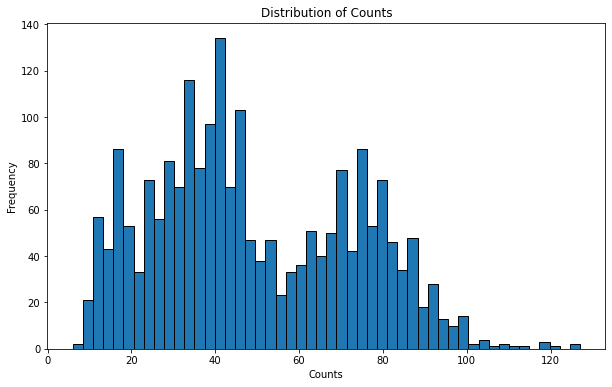

In [15]:
# 기본 통계 요약
print(datewise_counts.describe())

# 히스토그램
plt.figure(figsize=(10, 6))
datewise_counts.hist(bins=50, edgecolor='black')
plt.title("Distribution of Counts")
plt.xlabel("Counts")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [116]:
data_first_half.to_csv('eng_part1.csv', encoding='utf-8-sig', index=False)